In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

Precompiling packages...
  12926.2 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 15 seconds. 509 already precompiled.
[ Info: Precompiling SSMCMain [a75ad852-21c5-4a12-a12f-b1392bb0ea4b]


In [2]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions
using FreqTables

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [4]:
function do_single(Ns, Nr, params, lst, extinctthreshold, maxresidwarn)
    # numerically solve for the steady state
    u0 = ModifiedMiCRM.make_u0_onlyN(params)
    ssp = make_mmicrm_ss_problem(params, u0)
    ssps = solve(ssp, DynamicSS(QNDF()); reltol=maxresidwarn / 1000)

    if SciMLBase.successful_retcode(ssps.retcode)
        warning = false
        maxresid = maximum(abs, ssps.resid)
        if maxresid > maxresidwarn
            @printf "maxresid reached is %f > %f" maxresid maxresidwarn
            warning = true
        end

        if all(x->abs(x) < extinctthreshold, ssps.u[1:Ns])
            return -101
        end

        linstab_result = lst(params, ssps.u)
        if !warning
            if linstab_result 
                return 2 # spatial instability
            else
                return 1 # stable
            end
        else
            if linstab_result 
               return -2 # spatial instability but may be wrong
            else
                return -1 # stable but may be wrong
            end
        end
        
    else
        return -100
    end
end

function do_rg_run(rg, num_repeats, ks;
        extinctthreshold=1e-8,
        maxresidwarn=1e-5
    )
    @time "Generating one params" sample_params = rg()
    flush(stdout)
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # prep for the run
    lst = LinstabScanTester(ks, N, 0.)

    rslts = fill(0, num_repeats)
    @tasks for i in 1:num_repeats
        @local llst = copy(lst)
        
        params = rg()

        rslts[i] = do_single(Ns, Nr, params, llst, extinctthreshold, maxresidwarn)
        
        # @printf "Run %d -> %d\n" i rslts[i]
        # flush(stdout)
    end

    rslts
end

do_rg_run (generic function with 1 method)

# Testing

In [5]:
rsgj = RSGJans1(20, 20;
    m=1.,
    r=1.,
    Kp=1., K=0.5,
    
    c=2.,
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-8, DR=1.,
)
@time xx = do_rg_run(rsgj, 1000, LinRange(0., 100., 1000);
    extinctthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.000029 seconds (113 allocations: 78.875 KiB)
 32.451374 seconds (293.93 M allocations: 46.751 GiB, 6.59% gc time, 712.23% compilation time: <1% of which was recompilation)


1-element Named Vector{Int64}
Dim1  │ 
──────┼─────
1     │ 1000

In [108]:
rsgj = RSGJans1(20, 20;
    m=1.,
    r=1.,
    Kp=1., K=0.5,
    
    c=2.,
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-8, DR=1.,
)
@time xx = do_rg_run(rsgj, nthreads(), LinRange(0., 100., 1000);
    extinctthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.000488 seconds (113 allocations: 78.875 KiB)
  0.585502 seconds (4.86 M allocations: 834.809 MiB, 0.00% compilation time)


1-element Named Vector{Int64}
Dim1  │ 
──────┼───
1     │ 18

# Running a single system

In [7]:
ps = rsgj();

## No space solver

In [11]:
u0 = make_u0_smart(ps; u0=:maxNs)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF()); reltol=1e-9);
maximum(abs, sss.resid)

  0.018293 seconds (1.96 k allocations: 648.625 KiB)


9.155983565136388e-9

maximum(abs, (s.u[end])[1:(get_Ns(ps))[1]]) = 1.2913923020237864e-6


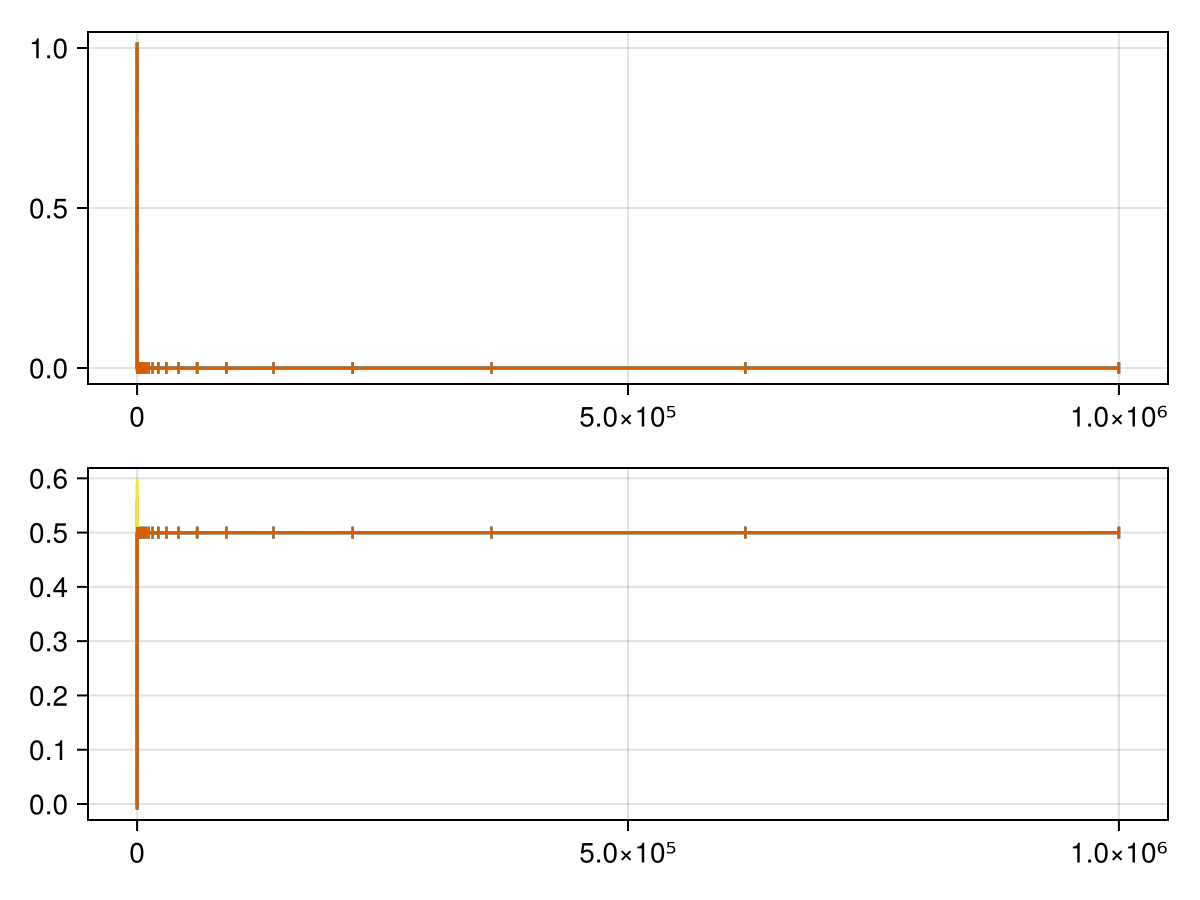

In [15]:
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 1000000);

s = solve(p)
@show maximum(abs, s.u[end][1:get_Ns(ps)[1]])

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

## Spatial stuff

In [66]:
nssol = s.u[end];
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 7.923578564151767e-16


### Linear stability

In [67]:
ks = LinRange(0., 1000., 1000)

lamfunc = linstab_make_k_func(ps, nssol)
lambdas = lamfunc.(ks);

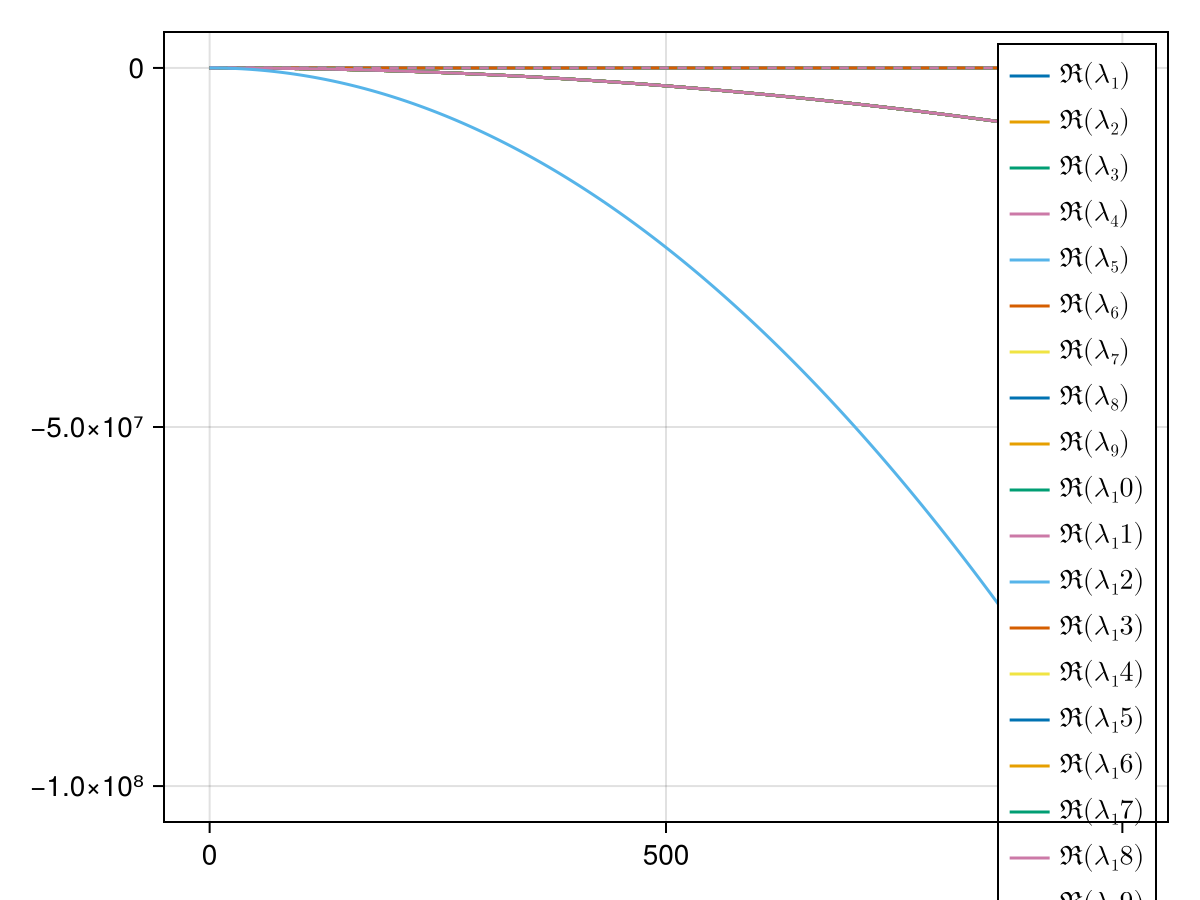

In [68]:
faa = plot_linstab_lambdas(ks, lambdas)
# display(GLMakie.Screen(), faa.figure)
faa

### 1D spatial

In [89]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [90]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

 20.937264 seconds (128.32 k allocations: 5.782 GiB, 2.01% gc time)
Success
nf is 880
solution has 150 saved states
max resid is 2.00273e-11


┌ Warning: reaching negative values, minimum is -3.32617e-06
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


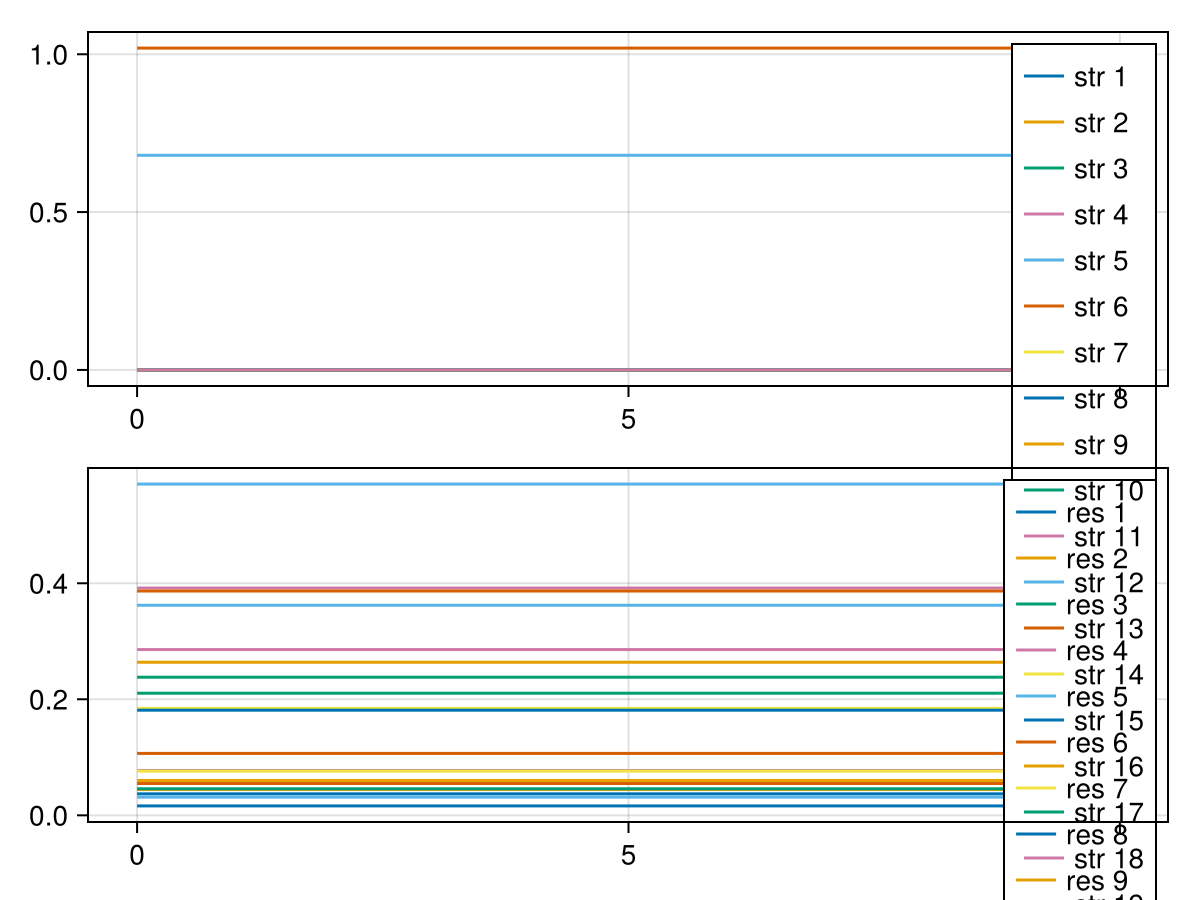

In [105]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[150])

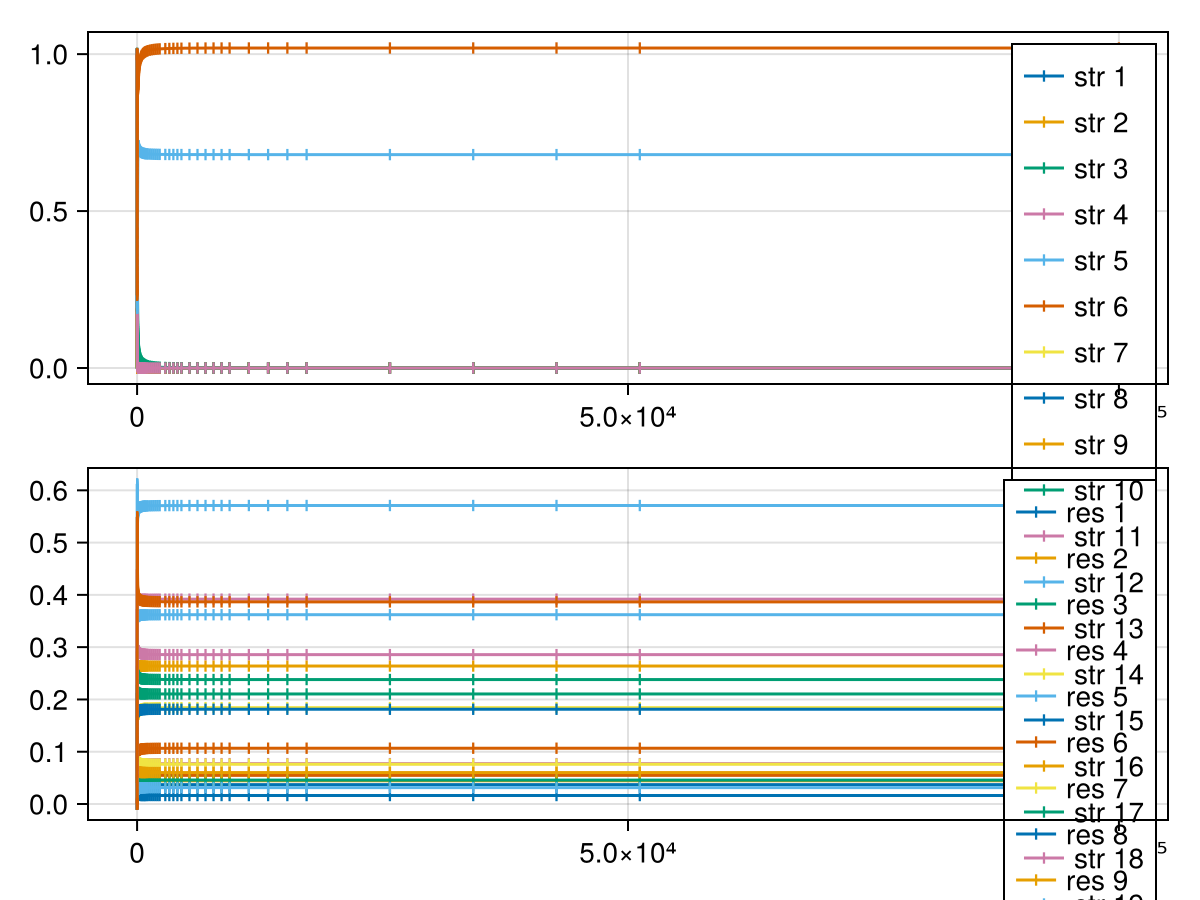

In [92]:
plot_smmicrm_sol_avgs(sps)

# Running Stevens generator

In [44]:
rsg = RSGStevens1(20, 20, 1., 0.35);
@time xx = do_rg_run(rsg, 1000, LinRange(0., 40., 10000);
    extinctthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.033824 seconds (40.34 k allocations: 8.685 MiB)
maxresid reached is 0.000011 > 0.000010maxresid reached is 0.000011 > 0.000010maxresid reached is 0.000042 > 0.000010maxresid reached is 0.000995 > 0.000010

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/7BHQj/src/integrator_interface.jl:589


487.655912 seconds (428.92 M allocations: 371.603 GiB, 6.12% gc time, 0.00% compilation time)


5-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   5
-100  │   1
-1    │   4
1     │ 979
2     │  11

# Bigger runs

In [114]:
bigrsg = RSGJans1(50, 50;
    m=1.,
    r=1.,
    Kp=0.1, K=10.0,
    
    c=(2., 1.),
    l=0.2,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)

@time xx = do_rg_run(rsgj, 1000, LinRange(0., 1000., 1000);
    extinctthreshold=1e-5
)

jldsave(datadir("randomsystems/prelim", randname()*".jld2");
    rsg=bigrsg,
    output=xx
)

freqtable(xx)

Generating one params: 0.000501 seconds (865 allocations: 1.265 MiB)
451.332197 seconds (3.80 G allocations: 174.887 GiB, 4.30% gc time, 0.00% compilation time)


3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │  14
1     │ 985
2     │   1

# Looking/comparing saved data

In [128]:
f = jldopen("../data/randomsystems/prelim/Proactive-Fuchsia-Mongoose.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   9
1     │ 987
2     │   4

In [134]:
f = jldopen("../data/randomsystems/prelim/Likable-Periwinkle-Viper.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   2
1     │ 994
2     │   4

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()